# Part 1: Building an item-item recommendation system from scratch

In [46]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Dataset

Let's download a small version of the [MovieLens](https://www.wikiwand.com/en/MovieLens) dataset. See [here](https://grouplens.org/datasets/movielens/) for zip file url, or directly download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). We're working with data in `ml-latest-small.zip` and will need to add the following files to our repository: 
- ratings.csv
- movies.csv

Alternatively, you can access the data here: 
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

We will use **pandas** to represent our data as DataFrames. 

#### What is a DataFrame? 

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table 
- documentation can be found [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

We use Pandas' `read_csv` method which can read csv files into a dataframe. For the code in this notebook to work, move the appropriate csv files into a directory called `data/`.

In [47]:
ratings = pd.read_csv("data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [48]:
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploratory Data Analysis

In [49]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()


print("Number of ratings:", n_ratings)
print("Number of unique movieId's:", n_movies)
print("Number of unique users:", n_users)
print("Average number of ratings per user:", round(n_ratings/n_users, 2))
print("Average number of ratings per movie:", round(n_ratings/n_movies, 2))

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


In [50]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count()

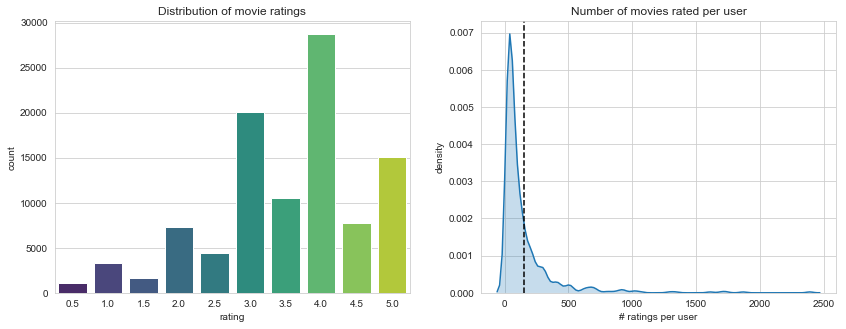

In [51]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['movieId'], shade=True, legend=False)
plt.axvline(user_freq['movieId'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

### Which movie has the lowest and highest average rating?

In [52]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
1062,1311,Santa with Muscles (1996),Comedy


In [53]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
50,53,Lamerica (1994),Adventure|Drama


### A Glimpse at Movie Genres

In [54]:
movies["genres"] = movies["genres"].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### How many genres are there?

In [55]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print("There are {:d} genres.".format(len(genre_frequency)))

genre_frequency

There are 20 genres.


Counter({'Adventure': 1117,
         'Animation': 447,
         'Children': 583,
         'Comedy': 3315,
         'Fantasy': 654,
         'Romance': 1545,
         'Drama': 4365,
         'Action': 1545,
         'Crime': 1100,
         'Thriller': 1729,
         'Horror': 877,
         'Mystery': 543,
         'Sci-Fi': 792,
         'Documentary': 495,
         'IMAX': 153,
         'War': 367,
         'Musical': 394,
         'Western': 168,
         'Film-Noir': 133,
         '(no genres listed)': 18})

In [56]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4365), ('Comedy', 3315), ('Thriller', 1729), ('Romance', 1545), ('Action', 1545)]


Let's also clean up the "title" column by remove the year.

In [57]:
title = movies['title'][0]

print(title)
def get_title(title):
    t = title.split(' ')
    t.pop()
    t = ' '.join(t)
    return t

get_title(title)

Toy Story (1995)


'Toy Story'

In [58]:
def get_year(title):
    t = title.split(' ')
    year = t.pop()
    year = year.strip('()')
    return year

get_year(title)

'1995'

In [59]:
movies['year'] = movies['title'].apply(get_year)
movies['title'] = movies['title'].apply(get_title) # re-writing title column

## Transforming the data

We are going to use a technique called [colaborative filtering]() to generate recommendations for users. This technique is based on the concept of "homophily" - similar users will like similar things. Collaborative filtering is a type of unsupervised learning that extracts meaning items for a given user based on what other similar users have liked. 

The first step is to transform our data into a user-item matrix - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any user or item features to generate recommendations.

<img src="images/user-movie-matrix.png" width="500px" align="left">

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/item ID.

In [60]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (item_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [61]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [62]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print("Matrix sparsity: {0:.2f}%".format(sparsity*100))

Matrix sparsity: 1.64%


<img src="images/knn.png" width="20%" align="right"/>
## Finding similar movies using k-Nearest Neighbours

This approach looks for the "k" nearest neighbours of a given movie using different distance metrics like cosine similarity, euclidean distance, etc. 

In [63]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [64]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)

print("Because you watched ", movie_titles[movie_id])
for i in similar_ids:
    print(movie_titles[i])

Because you watched  Toy Story
Toy Story 2
Star Wars: Episode IV - A New Hope
Forrest Gump
Independence Day (a.k.a. ID4)
Groundhog Day
Back to the Future
Jurassic Park
Shrek
Star Wars: Episode VI - Return of the Jedi
Pulp Fiction


You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [65]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10, metric="cosine")

print("Because you watched ", movie_titles[movie_id])
for i in similar_ids:
    print(movie_titles[i])

Because you watched  Toy Story
Toy Story 2
Star Wars: Episode IV - A New Hope
Forrest Gump
Independence Day (a.k.a. ID4)
Groundhog Day
Back to the Future
Jurassic Park
Shrek
Star Wars: Episode VI - Return of the Jedi
Pulp Fiction


### Cold Start Problem: What if a new movie hasn't been rated yet?

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the "genres" column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1. 

In [67]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','year', 'genres'])

In [84]:
from sklearn.metrics.pairwise import cosine_similarity

# create mapper that maps index to title and vice versa
movie_indices = dict(zip(movies['title'], list(movies.index)))
cosine_sim = cosine_similarity(movie_genres, movie_genres)

print("Dimensions of our genres cosine similarity matrix: ",cosine_sim.shape)

Dimensions of our genres cosine similarity matrix:  (9125, 9125)


In [102]:
title = movies['title'][0]
n_recommendations = 10

idx = movie_indices[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]
print("Recommendations for {:s}: ".format(title))
movies['title'].iloc[similar_movies]

Recommendations for Toy Story: 


1815                                                Antz
2506                                         Toy Story 2
3003             Adventures of Rocky and Bullwinkle, The
3217                           Emperor's New Groove, The
3805                                      Monsters, Inc.
6705                                     Shrek the Third
7146                             Tale of Despereaux, The
7945    Asterix and the Vikings (Astérix et les Vikings)
8366                                               Turbo
8676                                      Boxtrolls, The
Name: title, dtype: object

### Advanced: matrix factorization

One major issue of k-Nearest Neighbours is that it becomes computationally expensive as the user-item matrix increases in size. 

Matrix factorization is a technique that helps extract "latent" features from the user-item matrix by reducing dimensionality. It works by factorizing the user-item matrix $R_{ui}$ into 3 smaller matrices: $U$, $S$, $V$:

$$R_{ui} = U_{uk} \cdot S_{kk} \cdot V_{ki} $$

where $U_{uk}$ and $V_{ki}$ are compact representations of users and items in $k$ "feature" space. By compressing our original user-item matrix from $R$ to $k$ dimensions, we can reduce noise and get a smoother rendering of our user-item preferences. Let's reduce the dimensions of our utility matrix using Single Vector Decomposition (SVD) and see how our results turns out.

In [66]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, n_iter=10, random_state=42)
Z = svd.fit_transform(X)
similar_ids = find_similar_movies(movie_id, Z, k=10)

print("Because you watched ", movie_titles[movie_id])
for i in similar_ids:
    print(movie_titles[i])

Because you watched  Toy Story
Toy Story 2
Independence Day (a.k.a. ID4)
Star Wars: Episode IV - A New Hope
Forrest Gump
Groundhog Day
Shrek
Bug's Life, A
Jurassic Park
Back to the Future
Star Wars: Episode VI - Return of the Jedi
